In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from rich.console import Console

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels,  get_colored_masks, image_add_mask_boundary
from evaluation.eval_PartNet import load_images
from paper.paper_util import get_2d_tree_from_3d
import networkx as nx
import cv2


/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-15 11:09:47.994798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 11:09:49.144689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-15 11:09:49.144815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)
glctx = dr.RasterizeCudaContext()

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
# cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
print(f"Data Root: {data_root}")
image_dir = data_root.parent.joinpath('tree_seg')

save_root = Path('/data5/wan/PartNet_final/').expanduser()
print(f"Save Root:", save_root)
all_results = sorted(list(save_root.glob('*/my.tree3dv2')))
print(f'There are {len(all_results)} results')

categories = set()
results = {}

for result_path in all_results:
    obj_id = result_path.parts[-2]
    # print(result_path, obj_id)
    assert data_root.joinpath(obj_id).exists()
    with data_root.joinpath(obj_id, 'meta.json').open('r') as f:
        meta = json.load(f)
        cat = meta['model_cat']
    categories.add(cat)
    if cat not in results:
        results[cat] = []
    results[cat].append(result_path)

categories = sorted(list(categories))
print(f"Categories: {len(categories)}")
for cat in categories:
    print(f'Cat: {cat} have {len(results[cat])} results')


Data Root: /home/wan/data/PartNet/data_v0
Save Root: /data5/wan/PartNet_final
There are 1000 results
Categories: 24
Cat: Bag have 29 results
Cat: Bed have 37 results
Cat: Bottle have 49 results
Cat: Bowl have 38 results
Cat: Chair have 47 results
Cat: Clock have 49 results
Cat: Dishwasher have 44 results
Cat: Display have 48 results
Cat: Door have 43 results
Cat: Earphone have 45 results
Cat: Faucet have 49 results
Cat: Hat have 40 results
Cat: Keyboard have 27 results
Cat: Knife have 49 results
Cat: Lamp have 48 results
Cat: Laptop have 50 results
Cat: Microwave have 39 results
Cat: Mug have 34 results
Cat: Refrigerator have 31 results
Cat: Scissors have 12 results
Cat: StorageFurniture have 48 results
Cat: Table have 48 results
Cat: TrashCan have 48 results
Cat: Vase have 48 results


In [5]:
# show_cats = ['Bag', 'Bed', 'Bottle', 'Bowl', 'Chair', 'Clock', 'Dishwasher', 'Display', 'Door', 'Earphone', 'Faucet', 'Hat', 'Keyboard', 'Knife', 'Lamp', 'Laptop', 'Microwave', 'Mug', 'Refrigerator', 'Scissors', 'StorageFurniture', 'Table', 'TrashCan', 'Vase']
show_cats = [
    'Bed', 'Chair', 'Clock', 'Dishwasher', 'Display', 'Door', 'Earphone', 'Faucet', 'Knife', 'Lamp', 'Microwave',
    'Refrigerator', 'StorageFurniture', 'Table', 'Vase'
]
metric_names = ['SQ', 'RQ', 'TS', 'TQ', 'mIoU']

# 3D Tree Segmentation Results

In [6]:
scores = {}
all_metrics = {}
for cat in categories:
    scores[cat] = []
    metric = TreeSegmentMetric()
    for result_path in results[cat]:  # type: Path
        # print(result_path)
        mesh = torch.load(result_path.with_name(f'{result_path.parts[-2]}.mesh_cache'), map_location=device)
        # print(mesh)
        gt = Tree3Dv2(mesh, device=device)
        gt.load(result_path.with_name('gt.tree3dv2'))
        if gt.cnt == 0:
            continue

        prediction = Tree3Dv2(mesh, device=device)
        prediction.load(result_path)

        metric_t = TreeSegmentMetric()
        metric_t.update(prediction, gt)
        scores[cat].append(metric_t.TQ)
        metric.update(prediction, gt)

    all_metrics[cat] = metric

[Tree3D] load results from: /data5/wan/PartNet_final/12008/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/12008/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/13205/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/13205/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/13211/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/13213/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/13213/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/8964/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/8964/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/9027/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/9027/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/9052/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/9052/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/9071/gt.tree3dv2
[Tree3D] load

In [7]:
print(' & '.join([f"{'Cat':20}"] + [f"{s:6}" for s in metric_names]))
for cat in categories:
    if cat in categories:
        res = all_metrics[cat].summarize()
        print(' & '.join([f"{cat:20}"] + [f"{res[name]:.4f}" for name in metric_names]))

for name in metric_names:
    values = [getattr(all_metrics[cat], name) for cat in show_cats]
    values = [v.item() if isinstance(v, Tensor) else v for v in values]
    print('ours', name, f"{np.mean(values):.4f}", *[f"{v:.4f}" for v in values], sep=' & ', end='\\\\\n')


Cat                  & SQ     & RQ     & TS     & TQ     & mIoU  
Bag                  & 0.4361 & 0.1356 & 0.9670 & 0.1134 & 0.1795
Bed                  & 0.4967 & 0.0690 & 0.9615 & 0.0470 & 0.0803
Bottle               & 0.7255 & 0.3522 & 0.8695 & 0.2585 & 0.4347
Bowl                 & 0.5276 & 0.3793 & 0.7821 & 0.2963 & 0.3451
Chair                & 0.6479 & 0.2184 & 0.9451 & 0.1857 & 0.2427
Clock                & 0.5800 & 0.1676 & 0.8920 & 0.1167 & 0.1807
Dishwasher           & 0.2981 & 0.0414 & 0.8397 & 0.0296 & 0.0616
Display              & 0.7116 & 0.2227 & 0.9298 & 0.1746 & 0.3227
Door                 & 0.6148 & 0.1570 & 0.9272 & 0.1154 & 0.2054
Earphone             & 0.7277 & 0.1601 & 0.9293 & 0.1150 & 0.2449
Faucet               & 0.7561 & 0.2860 & 0.9463 & 0.2235 & 0.3880
Hat                  & 0.5846 & 0.2684 & 0.8808 & 0.1871 & 0.3483
Keyboard             & 0.4123 & 0.0300 & 0.9454 & 0.0198 & 0.0234
Knife                & 0.7635 & 0.3543 & 0.8845 & 0.2579 & 0.5367
Lamp      

In [8]:
index = categories.index('Faucet')
cat = categories[index]
scores_c = np.array([v.item() if isinstance(v, Tensor) else v for v in scores[cat]])
order = np.argsort(scores_c)[::-1]
print('Now Category:', cat)
print('scores:', scores_c[order])

Now Category: Faucet
scores: [0.5362 0.4246 0.4192 0.3935 0.3923 0.3919 0.3803 0.3745 0.3639 0.357  0.3564 0.3377 0.311  0.2966 0.2843 0.2842 0.2772
 0.2477 0.2447 0.2417 0.2406 0.2339 0.2309 0.2291 0.2285 0.2272 0.2229 0.2224 0.2116 0.2098 0.1998 0.1907 0.1826 0.1524
 0.1498 0.1443 0.1405 0.1376 0.1305 0.1015 0.0842 0.0765 0.0459 0.0255 0.0162 0.     0.     0.     0.    ]


In [9]:
best_mesh = results[cat][order[0]]
mesh = torch.load(best_mesh.with_name(f'{best_mesh.parts[-2]}.mesh_cache'))
print(mesh)
gt = Tree3Dv2(mesh, device=device)
gt.load(best_mesh.with_name('gt.tree3dv2'))
gt.to(device)

prediction = Tree3Dv2(mesh, device=device)
prediction.load(best_mesh)
prediction.to(device)

images, tri_ids, Tw2v = load_images(glctx, mesh, best_mesh.parent.joinpath('images'), num_views=100)
images = images.to(device)
tri_ids = tri_ids.to(device)
Tw2v = Tw2v.to(device)
mesh = mesh.to(device)
print(tri_ids.shape)
# chair /data5/wan/PartNet_final/42530/gt.tree3dv2, index: 60

Mesh(vertices=166798, faces=79755)
[Tree3D] load results from: /data5/wan/PartNet_final/1933/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/1933/my.tree3dv2
torch.Size([100, 512, 512])


index: 6


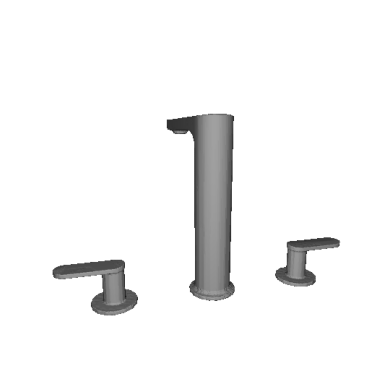

0: Tree Root
├── 1
├── 2
├── 3
│   ├── 7
│   └── 8
├── 4
│   ├── 9
│   └── 10
├── 5
│   ├── 11
│   └── 12
└── 6
    ├── 13
    └── 14

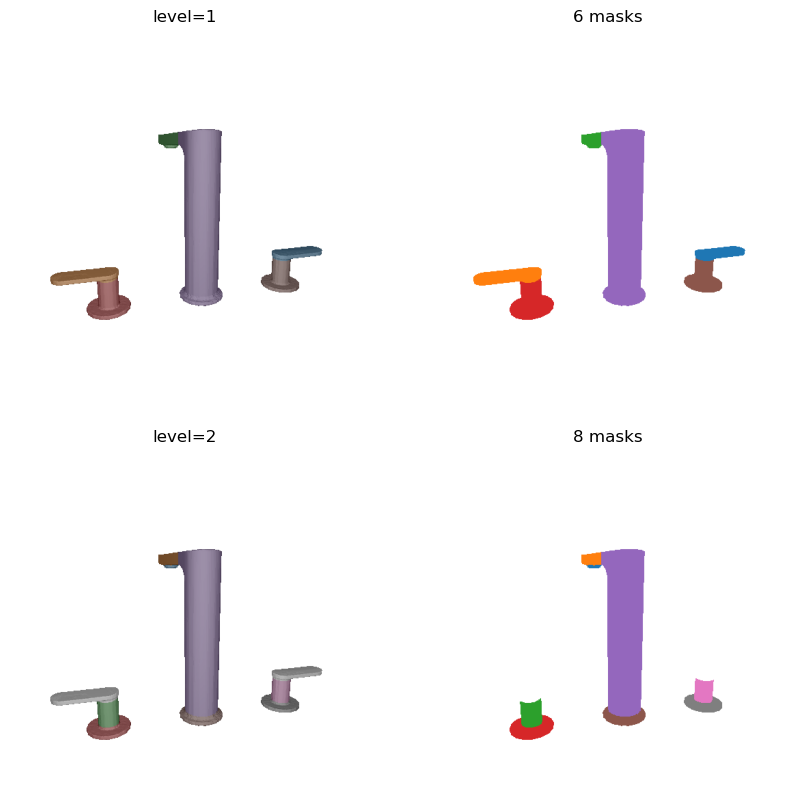

In [10]:
show_index = np.random.choice(len(images))
print('index:', show_index)
plt.imshow(images[show_index].cpu().numpy())
plt.axis('off')
plt.show()
show_all_levels(images[show_index,], gt, tri_ids[show_index])
gt.print_tree()

In [11]:
from evaluation.util import predictor_options, get_predictor
import argparse
parser = argparse.ArgumentParser()
predictor_options(parser)
args = parser.parse_args([])
predictor = get_predictor(args)

Loaded Model Semantic-SAM-l
build predictor


numpy((512, 512, 3), uint8)


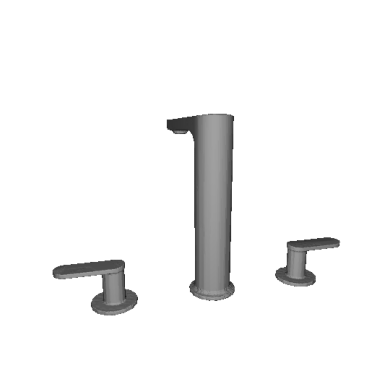

numpy((1024, 2), float64)


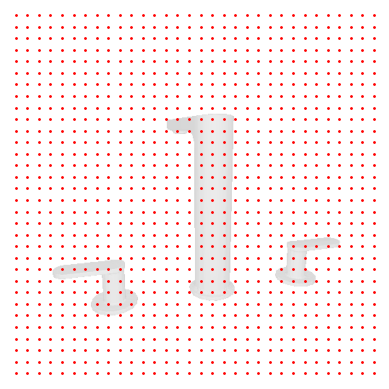

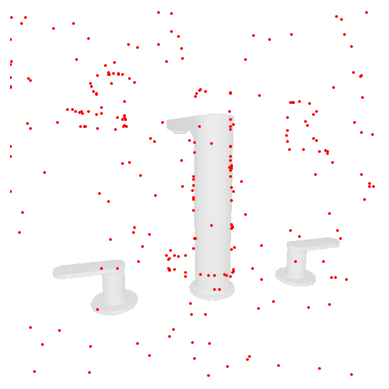

5

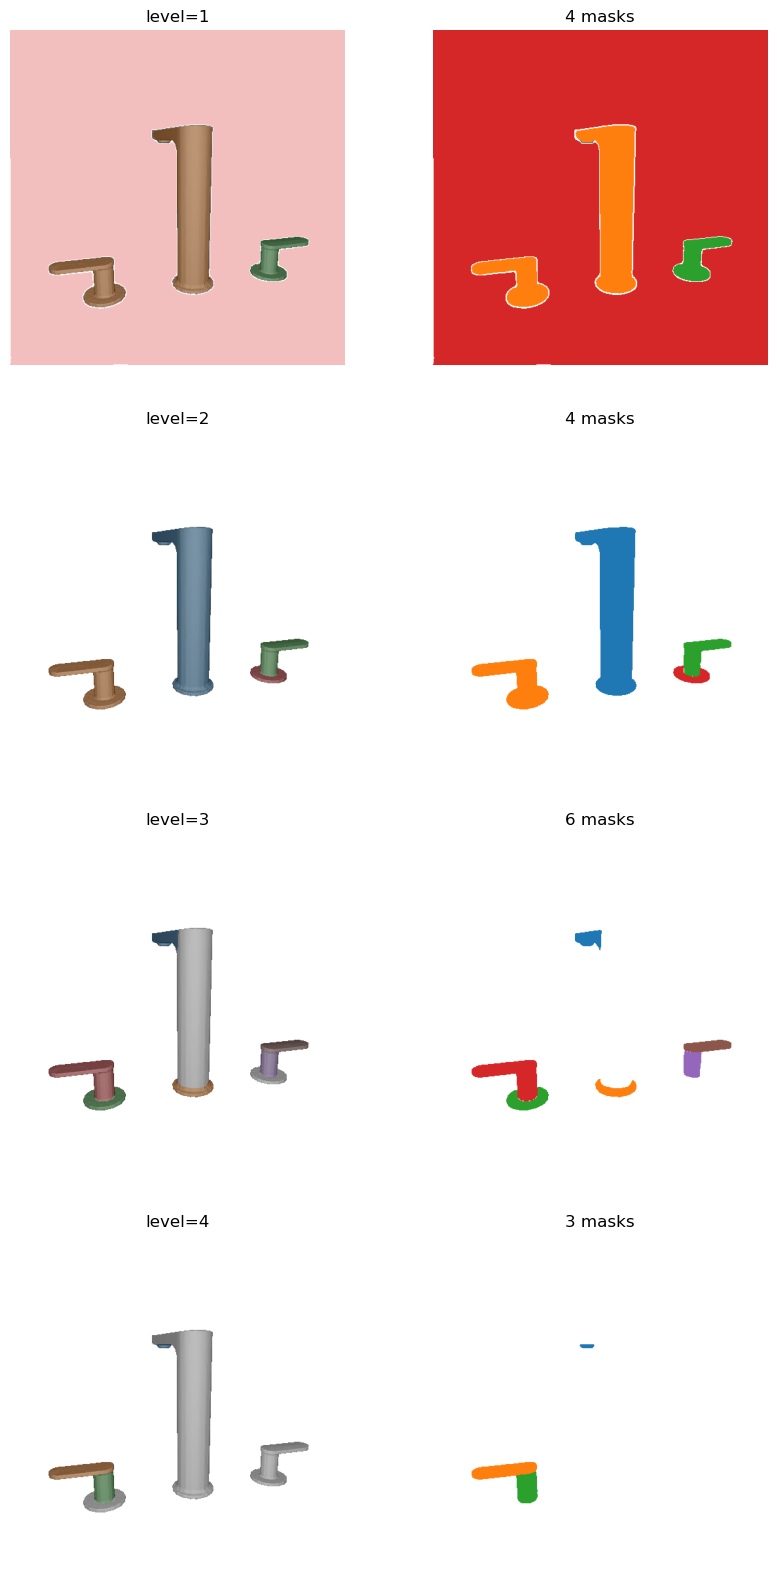

In [15]:
image = utils.as_np_image(images[show_index])
predictor.set_image(image)
print(utils.show_shape(image))
plt.imshow(image)
plt.axis('off')
plt.show()


tree2d = Tree2D(device=device)
points = tree2d.sample_grid()
print(utils.show_shape(points))
plt.imshow(image, extent=[0, 1, 0, 1], alpha=0.2)
plt.scatter(points[:, 0], points[:, 1], s=1, c='red')
plt.axis('off')
plt.show()

output = predictor.process_points(points)
# points(utils.show_shape(output._stats))
tree2d.cat(output['masks'], output['iou_preds'])
tree2d.update_tree()
tree2d.remove_not_in_tree()

points = tree2d.sample_by_counts(256)

plt.imshow(image, extent=[0, 1, 0, 1], alpha=0.2)
plt.scatter(points[:, 0], points[:, 1], s=1, c='red')
plt.axis('off')
plt.show()

output = predictor.process_points(points)
# points(utils.show_shape(output._stats))
tree2d.cat(output['masks'], output['iou_preds'])
tree2d.update_tree()
tree2d.remove_not_in_tree()

show_all_levels(image, tree2d)

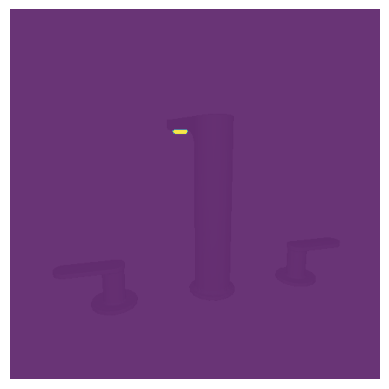

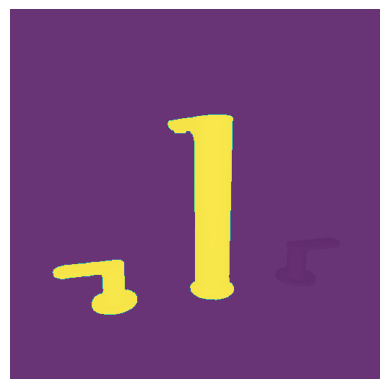

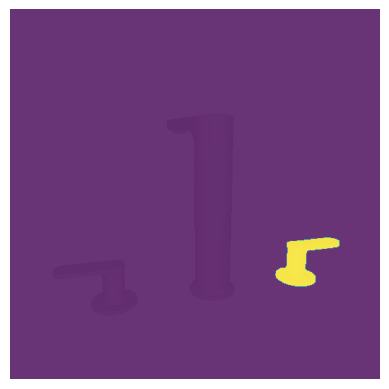

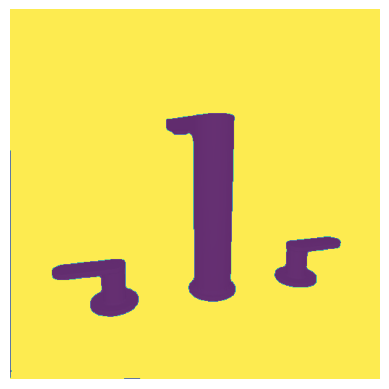

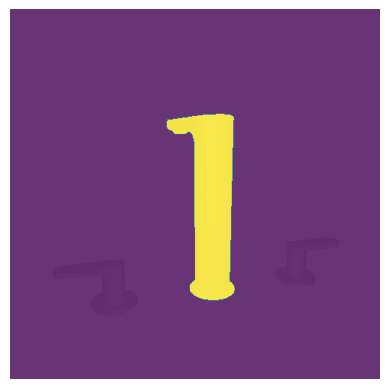

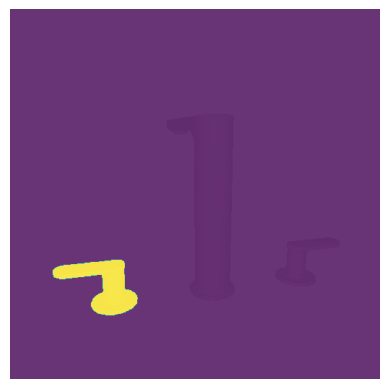

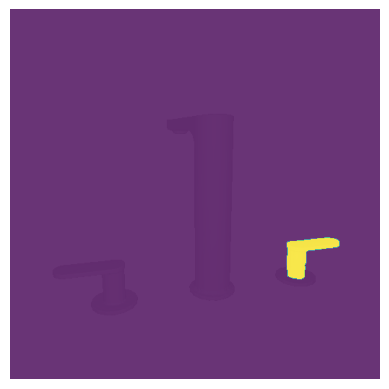

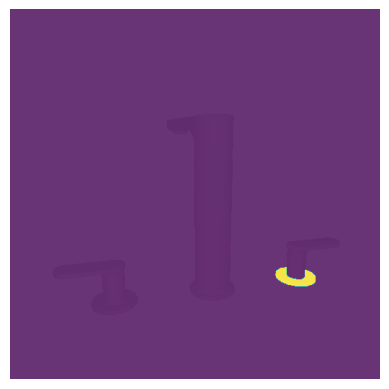

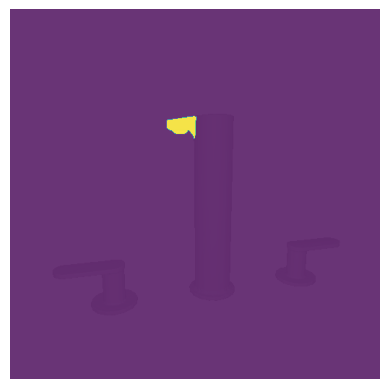

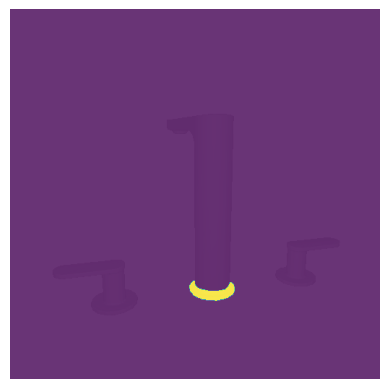

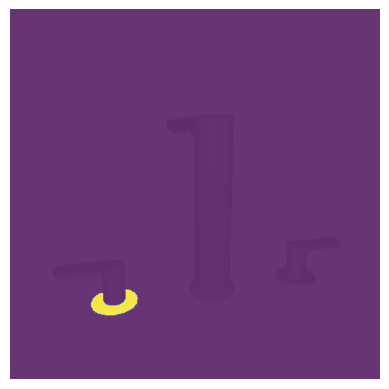

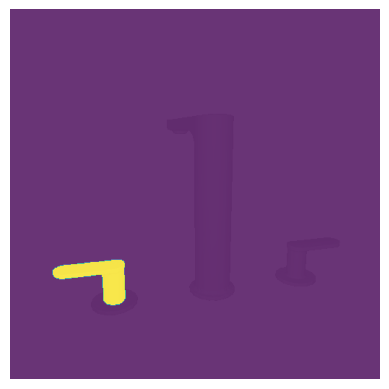

In [20]:
for i in range(tree2d.cnt):
    mask = tree2d.masks[i]
    plt.imshow(image, alpha=0.2)
    plt.imshow(mask.cpu().numpy()*255, alpha=0.8)
    plt.axis('off')
    plt.show()
    if i > 10:
        break

In [29]:
# save_dir = Path(f'./results/PartNet_{cat}_gt/view{show_index}')
# save_dir.mkdir(exist_ok=True, parents=True)
# save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
# save_3d_part_meshs(save_dir.parent, gt, mesh)

0: Tree Root
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
└── 8

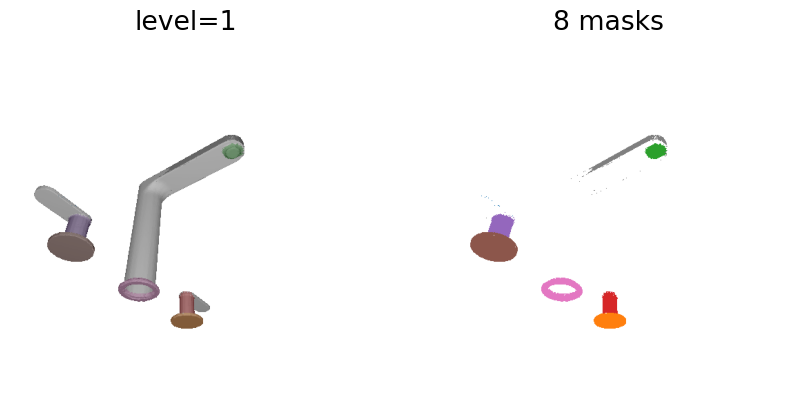

In [20]:
# show_index = 40
prediction.node_rearrange()
show_all_levels(images[show_index,], prediction, tri_ids[show_index])
prediction.print_tree()

In [31]:
# save_dir = Path(f'./results/PartNet_{cat}/view{show_index}')
# save_dir.mkdir(exist_ok=True, parents=True)
# save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
# save_3d_part_meshs(save_dir.parent, gt, mesh)

0: Tree Root
└── 1
    ├── 2
    │   ├── 8
    │   └── 9
    ├── 3
    │   └── 10
    ├── 4
    │   ├── 11
    │   └── 12
    ├── 5
    ├── 6
    └── 7

0: Tree Root
├── 1
│   ├── 4
│   └── 5
│       ├── 8
│       └── 9
├── 2
│   ├── 6
│   │   ├── 10
│   │   │   ├── 13
│   │   │   └── 14
│   │   └── 11
│   └── 7
│       └── 12
└── 3

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


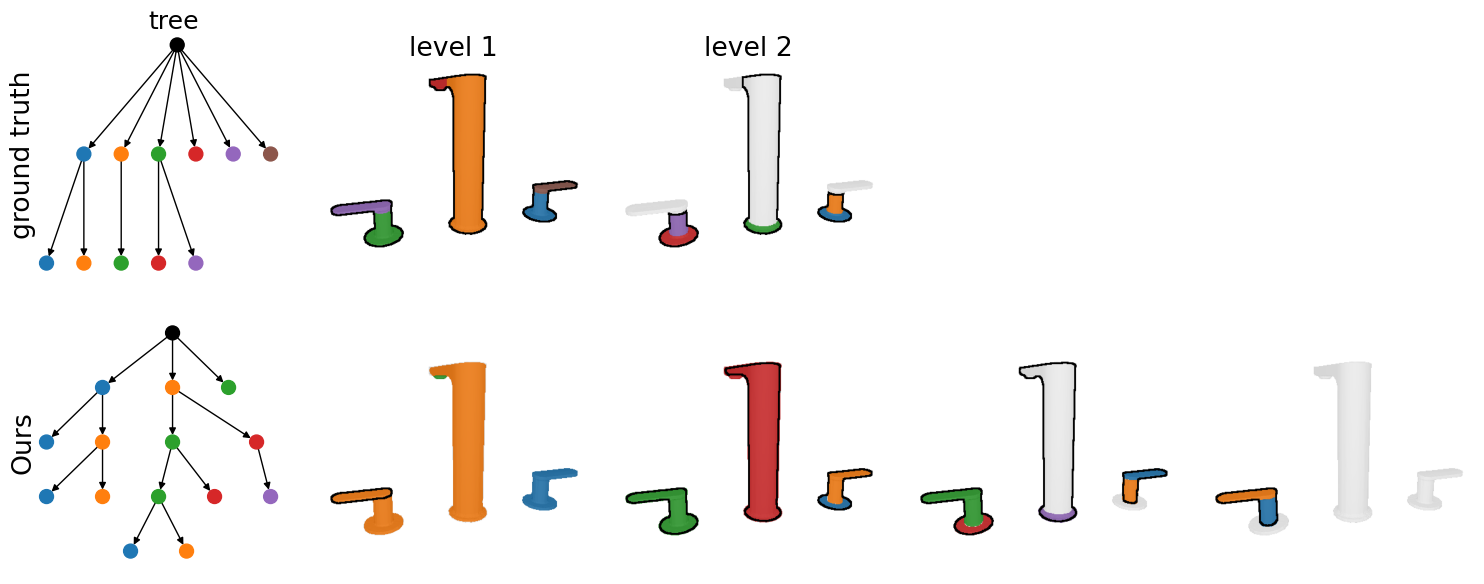

In [24]:
def show_compare(pred: Tree3Dv2, gt: Tree3Dv2, image: Tensor, tri_id: Tensor):
    if isinstance(image, Tensor):
        image = image.cpu().numpy()
    alpha = 0.2

    tree2d_p = get_2d_tree_from_3d(pred, tri_id)
    # tree2d_p = tree2d
    tree2d_p.remove_background(tri_ids[show_index].eq(0))
    tree2d_p.post_process()
    levels_p = tree2d_p.get_levels()[1:]

    tree2d_g = get_2d_tree_from_3d(gt, tri_id)
    levels_g = tree2d_g.get_levels()[2:]

    tree2d_g.print_tree()
    tree2d_p.print_tree()
    
    max_levels = max(len(levels_p), len(levels_g)) + 1

    width = 7.5 * 2
    plt.figure(figsize=(width, width / max_levels * 2))
    plt.rcParams.update({'font.size': 16})

    H, W = tri_id.shape
    mask = tri_id > 0
    row = torch.nonzero(mask.any(dim=1))
    col = torch.nonzero(mask.any(dim=0))
    left, right = max(0, col[0] - 20), min(W, col[-1] + 20)
    top, bottom = max(0, row[0] - 30), min(H, row[-1] + 10)

    Gg = nx.DiGraph()
    Gp = nx.DiGraph()
    node_colors_p = {}
    node_colors_g = {}

    for level in range(max_levels):
        if level < len(levels_g):
            plt.subplot(2, max_levels, level + 2)
            masks = tree2d_g.masks[levels_g[level] - 1]
            # print(utils.show_shape(masks))
            img_m = get_colored_masks(masks)
            img_l = cv2.addWeighted(image, alpha, img_m, 1 - alpha, 0)
            for x in levels_g[level]:
                x = x.item()
                p = tree2d_g.parent[x].item()
                mask = tree2d_g.masks[p - 1]
                img_l = image_add_mask_boundary(img_l, mask, color=(0, 0, 0), kernel_size=7)
                Gg.add_edge(p, x)
                mask = tree2d_g.masks[x - 1]
                pos = torch.nonzero(mask)[0]
                node_colors_g[x] = img_m[pos[0], pos[1]]

            plt.imshow(img_l[top:bottom, left:right])
            plt.axis('off')
            plt.title(f'level {level+1}', y=1.0, pad=0)
        if level < len(levels_p):
            plt.subplot(2, max_levels, level + 2 + max_levels)
            masks = tree2d_p.masks[levels_p[level] - 1]
            img_m = get_colored_masks(masks)
            img_l = cv2.addWeighted(image, alpha, img_m, 1 - alpha, 0)
            for x in levels_p[level]:
                x = x.item()
                p = tree2d_p.parent[x].item()
                mask = tree2d_p.masks[p - 1]
                img_l = image_add_mask_boundary(img_l, mask, color=(0, 0, 0), kernel_size=7)
                Gp.add_edge(p, x)
                mask = tree2d_p.masks[x - 1]
                pos = torch.nonzero(mask)[0]
                node_colors_p[x] = img_m[pos[0], pos[1]]
            plt.imshow(img_l[top:bottom, left:right])
            plt.axis('off')
            # plt.title(f'Ours level {level+1}', y=1.0, pad=-10)
    ax = plt.subplot(2, max_levels, 1)
    pos = nx.nx_agraph.graphviz_layout(Gg, prog='dot', root='0')
    # nx.draw_networkx_edges(Gg, pos, ax=ax)
    node_colors_g = [node_colors_g[n] if n in node_colors_g else (0., 0., 0.) for n in Gg.nodes]
    nx.draw_networkx(Gg, pos, ax=ax, with_labels=False, node_color=node_colors_g, node_size=100)
    ax.set_title('ground truth', x=0, y=0.5, rotation=90, pad=0, va='center')
    ax.axis('off')

    print(Gp.nodes)
    node_colors_p = [node_colors_p[n] if n in node_colors_p else (0., 0., 0.) for n in Gp.nodes]
    ax = plt.subplot(2, max_levels, max_levels + 1)
    pos = nx.nx_agraph.graphviz_layout(Gp, prog='dot', root='1')
    nx.draw_networkx(Gp, pos, ax=ax, with_labels=False, node_color=node_colors_p, node_size=100)
    ax.set_title('Ours', x=0, y=0.5, rotation=90, pad=0, va='center')
    ax.axis('off')
    plt.gcf().text(0.1, 0.95, 'tree', fontsize=18)
    plt.tight_layout()
    plt.savefig('./results/chair.png')
    plt.show()


show_compare(prediction, gt, images[show_index], tri_ids[show_index])

In [11]:
ss = "SQ: 0.3011, RQ: 0.6665, PQ: 0.1867, TS: 0.8193, TQ: 0.1490, mIoU: 0.2938"
print(' & '.join([s.split(':')[1].strip() for s in ss.split(',')]))

0.3011 & 0.6665 & 0.1867 & 0.8193 & 0.1490 & 0.2938
